# ABOUT
__Author__: Pat McCornack

__Purpose__: Evaluate model results. 

In [34]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np

import rasterio
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

sns.set_style('whitegrid')

# Define Filepaths

In [35]:
local_root_dir = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\Fuel Attributes Model"
pnnl_root_dir = r"\\pnl\projects\BPAWildfire\data\Landfire\fuels_modeling\Fuel Attributes Model"

# Define which data directory to work off of
active_root_dir = pnnl_root_dir

# Define filepaths
paths_dict = {
    'ref_data_dir' : os.path.join(active_root_dir, r"..\LF_raster_data\_tables"),  # used by read_ref_data
    'results_outdir' : os.path.join(active_root_dir, r'model_outputs\tabular'),

    # Rasters
    'LF22_FDST' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\LC22_FDst_230_bpa.tif"),

    'pred_FVT_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\_predicted_rasters\LF22_Pred_FVT_2024-05-15_14-29-34.tif"),
    'og_FVT_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\LC22_FVT_230_bpa.tif"),

    'pred_F40_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\_predicted_rasters\LF22_Pred_F40_2024-05-15_17-17-25.tif"),
    'pred_F40_with_FVT_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\_predicted_rasters\LF22_F40_Pred_with_Pred_FVT_2024-05-14_16-57-02.tif"),
    'og_F40_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\LC22_F40_230_bpa.tif"),

    'pred_FVC_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\_predicted_rasters\LF22_Pred_FVC_2024-05-15_16-05-50.tif"),
    'og_FVC_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\LC22_FVC_230_bpa.tif"),

    'pred_FVH_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\_predicted_rasters\LF22_Pred_FVH_2024-05-16_09-11-35.tif"),
    'og_FVH_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\LC22_FVH_230_bpa.tif"),

    # Outfiles
    'results_outdir' : os.path.join(active_root_dir, r'model_outputs\tabular'),
    'FVC_results_fname' : 'results_LF22_Pred_FVT_2024-05-06_12-02-39.csv',
    'FVT_results_fname' : 'LF22_Pred_FVC_2024-05-15_09-26-36.csv'
}



# __Functions__
----

## __Visualizations__

### __Plot the Class Distribution__
Plots the distribution of the variable of interest. Can be set to display the raw counts for each class or the percentage of the dataste that the class accounts for. 

In [36]:
def plot_distribution(df, group_var, metric='Count', sort=True, title=f'Distribution', figsize=(15, 50)):
    """
    Plots the distribution of group_var. 'metric' can be set to either 'Count' or 'Percent' to change the display type. 
    The 'sort' argument specifies whether to sort the display in order from most common to least common. 
    """
    # Get count of target class
    df_gp = df.groupby(group_var).count().reset_index()
    df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

    # Get classes proportional representation
    df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
    df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str
    if sort == True: 
        df_gp = df_gp.sort_values(by="Count", ascending=True)

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    hbars = ax.barh(df_gp[group_var],
                df_gp[metric],
                align='center')
    ax.set(title=title,
        xlabel= f'{metric}', 
        ylabel=f'{group_var}')  
    ax.bar_label(hbars, fmt=" %.2f")
    
    # Remove whitespace at margins
    plt.ylim(ax.patches[0].get_y(), ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

### __Compare the Distribution of the Misclasses vs. Actual__
Plot a graph to see how the distribution of the misclasses compares with the distribution of the true classes. Metric can be set to 'Count' for raw counts or 'Percent'. If metric='Percent', then the 'total' value represents the percent representation of that class in the original dataset (e.g. Tr Northern Rocky Mountain Dry-Mesic Montane Mixed Conifer Forest accounts for 7.47% of observations in the true dataset), and the 'Misclass' value is the percent proportion of the misclassification data (e.g. Tr Northern Rocky Mountain Dry-Mesic Montane Mixed Conifer Forest accounts for 9.91% of all misclassed observations).

In [37]:
def plot_comparison_distribution(df_dict, group_var, metric='Count', sort=True, title=f'Distribution', figsize=(15, 50)):
    """
    Plots distributions of the true vs. misclassed datasets.

    Arguments:
    df_dict: Dictionary with the keys 'total' and 'misclass'. The corresponding values should be dataframes, where the 'total'
    dataframe is the original predictions subset to only include target classes found in the 'misclass' set and the 'misclass' dataframe
    is the original predictions subset to observations where the predicted target value does not match the actual. 

    metric = 'Count' / 'Percent' : Changes how to view the data - by raw counts or by proportions. 

    sort = True/False : Choose whether to sort the data before displaying it. 
    """
    
    df_gp_dict = {}
    
    # Aggregate the data
    for key, df in df_dict.items():
        # Get count of target class
        df_gp = df.groupby(group_var).count().reset_index()
        df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

        # Get classes proportional representation
        df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
        df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str

        df_gp_dict[key] = df_gp

    # sort values before plotting
    if sort == True:
        df_gp_dict['misclass'] = df_gp_dict['misclass'].sort_values(by=metric)
        df_gp_dict['total'] = df_gp_dict['total'].reindex(df_gp_dict['misclass'].index)

    # Set up to plot side-by-side
    ind = np.arange(len(df_gp_dict['misclass'])) # The y locations for groups
    width = 0.4

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    total_bar = ax.barh(ind+width/2, df_gp_dict['total'][metric], width, label='Total')
    misclass_bar = ax.barh(ind-width/2, df_gp_dict['misclass'][metric], width, label='Misclass')

    ax.set_title(title)
    ax.set_xlabel(f'{metric}')
    ax.set_yticks(ind)
    ax.set_yticklabels(df_gp_dict['misclass'][group_var].values)
    ax.legend(loc='right')
    ax.bar_label(total_bar, fmt=" %.2f")
    ax.bar_label(misclass_bar, fmt=" %.2f")

    # Remove whitespace at margins
    plt.ylim(ax.patches[0].get_y()-0.5, ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

### __Assess the Proportion of the Actual Values that were Misclasses__
Create a plot to display the percentage of each class that was misclassified alongside that classes total representation in the dataset. Setting the 'metric' argument will only affect how the total representation is displayed - by 'Count' or 'Percent' - the misclassified proportion will not change. 

In [38]:
# Plots the percent of the total class the misclass count is
def plot_percent_total(df_dict, group_var, sort=True, title=f'Distribution', metric='Count', figsize=(15, 50)):
    """
    Plots the proportion of each class that was misclassified, alongside its total representation in the dataset. 

    Arguments:
    df_dict: Dictionary with the keys 'total' and 'misclass'. The corresponding values should be dataframes, where the 'total'
    dataframe is the original predictions subset to only include target classes found in the 'misclass' set and the 'misclass' dataframe
    is the original predictions subset to observations where the predicted target value does not match the actual. 

    metric = 'Count' / 'Percent' : Changes how to view the data - by raw counts or by proportions. 

    sort = True/False : Choose whether to sort the data before displaying it. 
    """
    
    df_gp_dict = {}
    
    # Aggregate the data
    for key, df in df_dict.items():
        # Get count of target class
        df_gp = df.groupby(group_var).count().reset_index()
        df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

        # Get classes proportional representation
        df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
        df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str

        df_gp_dict[key] = df_gp

    # Calculate percent of total 
    total_perc = df_gp_dict['misclass']['Count'] / df_gp_dict['total']['Count'] * 100

    # Sort the data before plotting
    if sort == True:
        total_perc = total_perc.sort_values()
        df_gp_dict['total'] = df_gp_dict['total'].reindex(total_perc.index)

    # Set up to plot side-by-side
    ind = np.arange(len(total_perc)) # The y locations for groups
    width = 0.4

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    total_count_bar = ax.barh(ind-width/2, df_gp_dict['total'][metric], width, label=f'Total {metric}')
    total_perc_bar = ax.barh(ind+width/2, total_perc, width, label='Misclass Percent')
  
    ax.set_title(title)
    ax.set_xlabel('Percent')
    ax.set_yticks(ind)
    ax.set_yticklabels(df_gp_dict['total'][group_var].values)
    ax.legend(loc='right')
    ax.bar_label(total_perc_bar, fmt=" %.2f")
    ax.bar_label(total_count_bar, fmt=f" %.2f")

    # Remove whitespace at margins
    plt.ylim(ax.patches[0].get_y()-0.5, ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

## __Data Processing__

### __Create Data Dictionaries to Append Features__
Some features are separate attributes of the LANDFIRE dataset (e.g. BPS Fire Regime) and others are useful for results analysis (e.g. FDst attributes). These can be mapped to points using LANDFIRE CSVs. The below creates dictionaries to perform that mapping. 

This function is called by join_features.

In [39]:
def read_ref_data(ref_data_dir=paths_dict['ref_data_dir']):
    """
    Returns a dictionary of dictionaries of mappings between LANDFIRE raster values and other attributes associated with those values. 
    """
    data_dir = ref_data_dir
    LF22_FVT_fname = "LF22_FVT_230.csv"
    LF22_FVC_fname = "LF22_FVC_230.csv"
    LF22_FVH_fname = "LF22_FVH_230.csv"
    
    # Create empty dictionary
    LF_ref_dicts = {}

    # Join fuel type names from values
    LF22_FVT_df = pd.read_csv(os.path.join(data_dir, LF22_FVT_fname))
    LF_ref_dicts['Original_FVT_NAME'] = dict(LF22_FVT_df[['VALUE', 'EVT_FUEL_N']].values)
    LF_ref_dicts['Predicted_FVT_NAME'] = dict(LF22_FVT_df[['VALUE', 'EVT_FUEL_N']].values)
   
    # Join fuel cover names from values
    LF22_FVC_df = pd.read_csv(os.path.join(data_dir, LF22_FVC_fname))
    LF_ref_dicts['Original_FVC_NAME'] = dict(LF22_FVC_df[['VALUE', 'CLASSNAMES']].values)
    LF_ref_dicts['Predicted_FVC_NAME'] = dict(LF22_FVC_df[['VALUE', 'CLASSNAMES']].values)

    # Join fuel height names from values
    LF22_FVH_df = pd.read_csv(os.path.join(data_dir, LF22_FVH_fname))
    LF_ref_dicts['Original_FVH_NAME'] = dict(LF22_FVH_df[['VALUE', 'CLASSNAMES']].values)
    LF_ref_dicts['Predicted_FVH_NAME'] = dict(LF22_FVH_df[['VALUE', 'CLASSNAMES']].values)

    return LF_ref_dicts
                         
        

### __Append Features using Data Dictionaries__
Append in selected features using the LANDFIRE data dictionaries.

__Note:__ Items in feature_list must be in the source_layers dictionary. 

# __FVT Predictions Evaluation__ 

## __Summary Statistics__ 

In [23]:
# Read in data 
raster_fpaths_dict = {
    "Predictions" : paths_dict['pred_FVT_raster'],
    "Original" : paths_dict['og_FVT_raster'],
    "LF22_FDST"  : paths_dict['LF22_FDST']
    }

data_dict = {}
for var, item in raster_fpaths_dict.items():
    with rasterio.open(item) as src:
        data = src.read()
        data_dict[var] = data.ravel()

# Create dataframe from dictionary of predictions/original
df = pd.DataFrame(data_dict)

# Process the data
## Remove observations with -9999/-1111 in any field 
df = df.loc[~df.isin([-1111, -9999]).any(axis=1)]

## Filter out points that weren't disturbed
df = df.loc[df['LF22_FDST'] != 0]

## Filter out agricultural and developed points
developed_fvt = list(range(20,33)) + list(range(2901,2906))
ag_fvt = [80, 81, 82] + list(range(2960, 2971))
fvt_filter = developed_fvt + ag_fvt
df = df.loc[~df['Original'].isin(fvt_filter)]

In [24]:
# Get accuracy
misclass = df.loc[df['Original'] != df['Predictions']]
acc_perc = round((len(df) - len(misclass)) / len(df) * 100, 2)
print(f'Misclass Count: {len(misclass)} of {len(df)}')
print(f'Accuracy: {acc_perc}%')

Misclass Count: 15411182 of 144779061
Accuracy: 89.36%


In [ ]:
# Get results
results_dict = {
  "accuracy" : accuracy_score(df['Original'], df['Predictions']),
  "recall" : recall_score(df['Original'], df['Predictions'], average='macro', zero_division='warn'),
  "precision" : precision_score(df['Original'], df['Predictions'], average='macro', zero_division='warn')
}

results = pd.DataFrame([results_dict])
results

,accuracy,recall,precision
0,0.893554,0.614107,0.53183


## __FVT Visualizations__

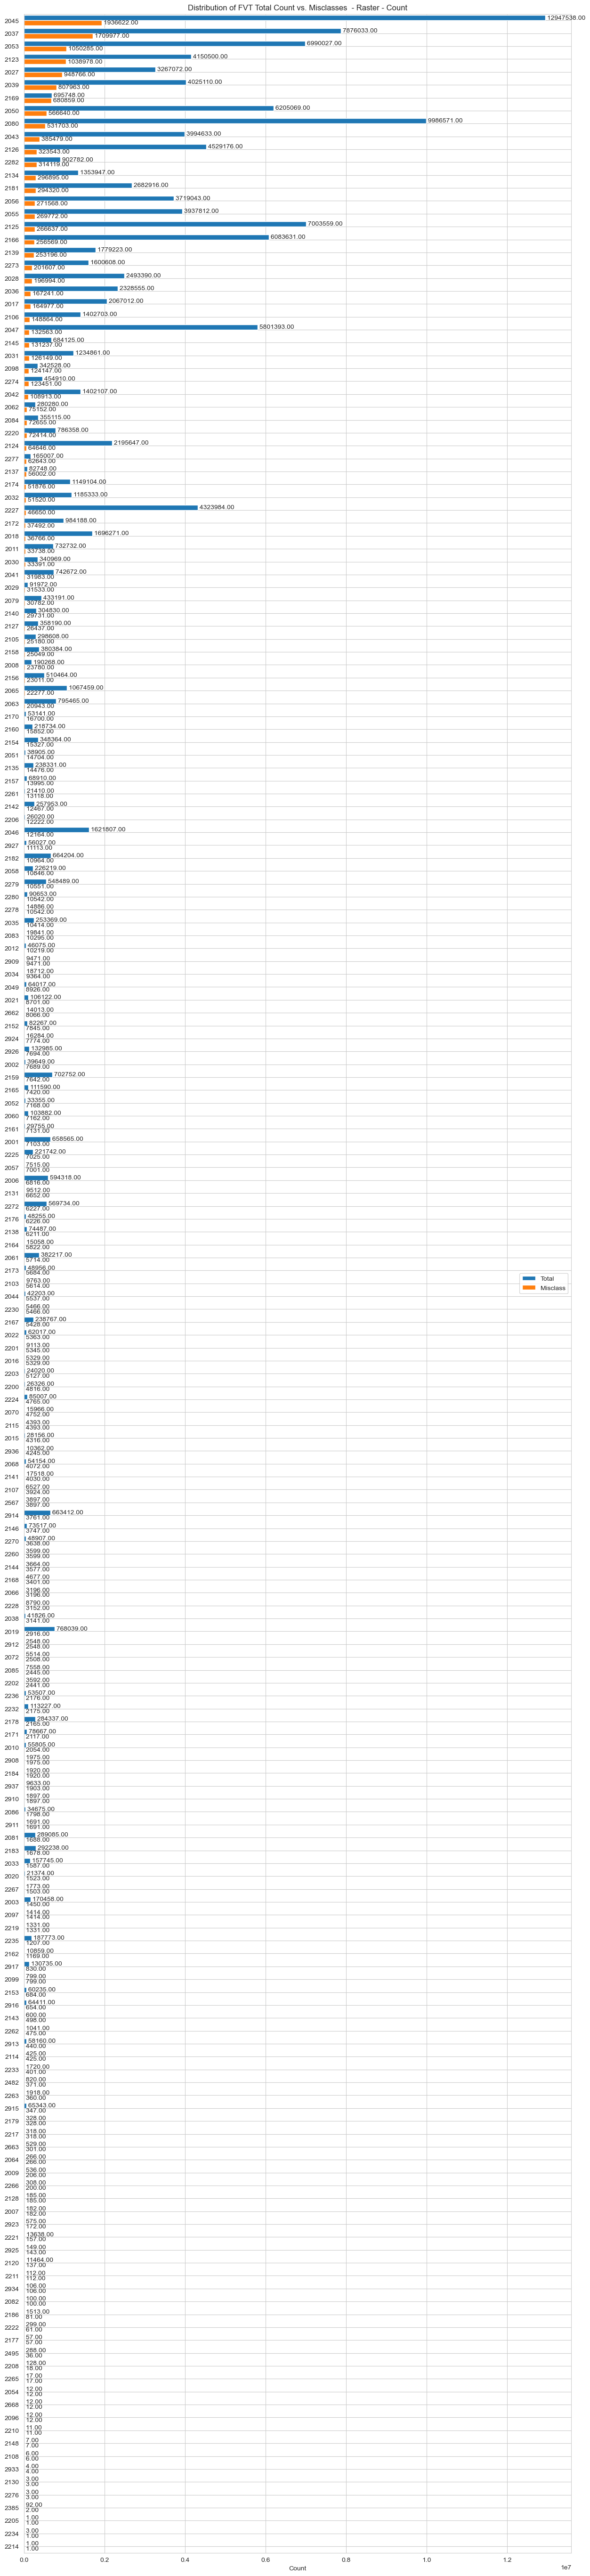

In [25]:

# Subset to misclassified observations
misclass = df.loc[~(df['Original'] == df['Predictions'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = df.loc[df['Original'].isin(misclass['Original'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Count'
title = f'Distribution of FVT Total Count vs. Misclasses  - Raster - {metric}'
plot_comparison_distribution(df_dict=df_dict, group_var='Original', metric=metric, title=title, figsize=(15, 70))


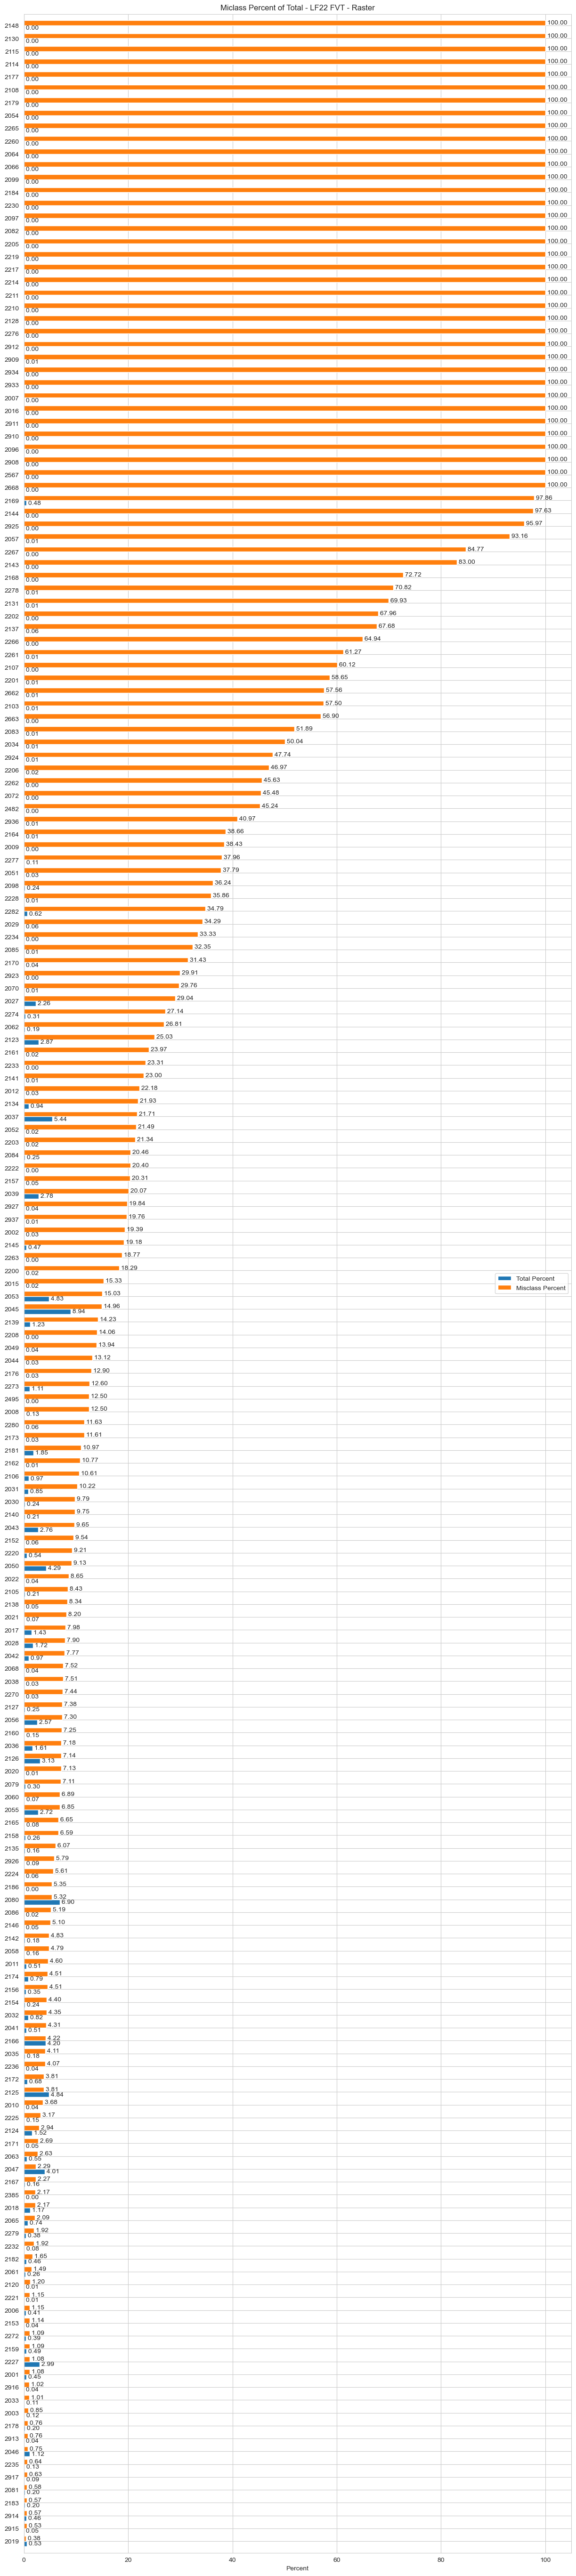

In [26]:
# Subset to misclassified observations
misclass = df.loc[~(df['Original'] == df['Predictions'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = df.loc[df['Original'].isin(misclass['Original'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Percent'
title = "Miclass Percent of Total - LF22 FVT - Raster"
plot_percent_total(df_dict=df_dict, group_var='Original', metric=metric, title=title, figsize=(15, 70))

##  __FVT Pyrologic Similarity__
Note that these metrics are based on disturbed cells only. 


### Read and Process Data

In [ ]:
# Read in data 
raster_fpaths_dict = {
    "FVT_Original" : paths_dict['og_FVT_raster'],
    "FVT_Predictions" : paths_dict['pred_FVT_raster'],
    "F40_Original" : paths_dict['og_F40_raster'],
    "F40_Predictions" : paths_dict['pred_F40_with_FVT_raster'],
    "LF22_FDST"  : paths_dict['LF22_FDST']
    }

data_dict = {}
for var, item in raster_fpaths_dict.items():
    with rasterio.open(item) as src:
        data = src.read()
        data_dict[var] = data.ravel()

# Create dataframe from dictionary of predictions/original
df = pd.DataFrame(data_dict)
df.head()


RasterioIOError: \\pnl\projects\BPAWildfire\data\Landfire\fuels_modeling\Fuel Attributes Model\..\LF_raster_data\bpa_service_territory\_predicted_rasters\LF22_F40_Pred_with_Pred_FVT_2024-05-14_16-57-02.tif: TIFFReadDirectory:Failed to read directory at offset 3195062082

In [ ]:
# Process the data
# Remove observations with -9999/-1111 in any field 
df = df.loc[~df.isin([-1111, -9999]).any(axis=1)]
print(f"After removing null points: {df.shape[0]}")

# Filter out points that weren't disturbed
df = df.loc[~(df['LF22_FDST'] == 0)]
print(f"After removing undisturbed points: {df.shape[0]}")

# Filter out agricultural and developed points
developed_fvt = list(range(20,33)) + list(range(2901,2906))
ag_fvt = [80, 81, 82] + list(range(2960, 2971))
fvt_filter = developed_fvt + ag_fvt
df = df.loc[~df['Original'].isin(fvt_filter)]

In [ ]:
# Get results
results_dict = {
  "FVT_accuracy" : accuracy_score(df['FVT_Original'], df['FVT_Predictions']),
  "F40_accuracy" : accuracy_score(df['F40_Original'], df['F40_Original'])
}

results = pd.DataFrame([results_dict])
print(results)

### Add in match/no-match features

In [ ]:
# Create features based on whether predictions were accurate
df['FVT_Correct'] = df['FVT_Original'] == df['FVT_df']
df['F40_Correct'] = df['F40_Original'] == df['F40_df']
df.head()

### Calculate adjusted FVT accuracy
The adjusted FVT accuracy considers the FVT to be correct if: 
1. The FVT was correctly classified, or
2. The FVT was incorrectly classified, but the F40 was correctly classified

The ultimate goal of this process is to use the FVT raster as a predictor in the F40 model. Therefore, if the FVT was incorrectly classified but the F40 was correctly classified then we consider the FVT to be 'pyrologically similar' and correct for our purposes. 

In [ ]:
# What is the overall accuracy of the FVT model considering 'pyrologic similarity'? 
FVT_corr_cnt = df.loc[df['FVT_Correct'] == True].shape[0]
FVT_corr_perc = round(FVT_corr_cnt / df.shape[0] * 100, 2)

FVT_incorr_F40_corr_cnt = df.loc[(df['FVT_Correct'] ==  False) & (df['F40_Correct']) == True].shape[0]
FVT_incorr_F40_corr_perc = round(FVT_incorr_F40_corr_cnt / df.shape[0] * 100, 2)

FVT_acc_adj_cnt = FVT_corr_cnt + FVT_incorr_F40_corr_cnt
FVT_acc_adj_perc = round(FVT_acc_adj_cnt / df.shape[0] * 100, 2)

print(f"Overall FVT Accuracy: {FVT_corr_perc}% ({FVT_corr_cnt} out of {df.shape[0]})")
print(f"Frequency of incorrect FVTs with correct F40s: {FVT_incorr_F40_corr_perc}% ({FVT_incorr_F40_corr_cnt} out of {df.shape[0]})")
print(f"Adjusted FVT Accuracy: {FVT_acc_adj_perc}% ({FVT_acc_adj_cnt} out of {df.shape[0]})")


Overall FVT Accuracy: 89.41% (144591 out of 161723)
Frequency of incorrect FVTs with correct F40s: 3.03% (4901 out of 161723)
Adjusted FVT Accuracy: 92.44% (149492 out of 161723)


### F40 Misclassification Differences
For cases where FVT is incorrect and F40 is incorrect, what is the difference between the acutal and predicted F40? 

F40 classes with similar values can generally be considered to have similar fuels characteristics, so a difference of 1 would likely have little impact on the fire behavior modeling. Note that differences in multiples of 20 indicate that the fuels "parent class" was misclassified due to how the data is structured (e.g. a difference of 20 may indicate that a 'Grass' was classified as a 'Grass-Shrub') - hence the clustered nature of the graph. 

C:\Users\mcco573\AppData\Local\Temp\ipykernel_21444\3037083262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['F40_diff'] = df['LF22_F40'] - df['PRED_LF22_F40']


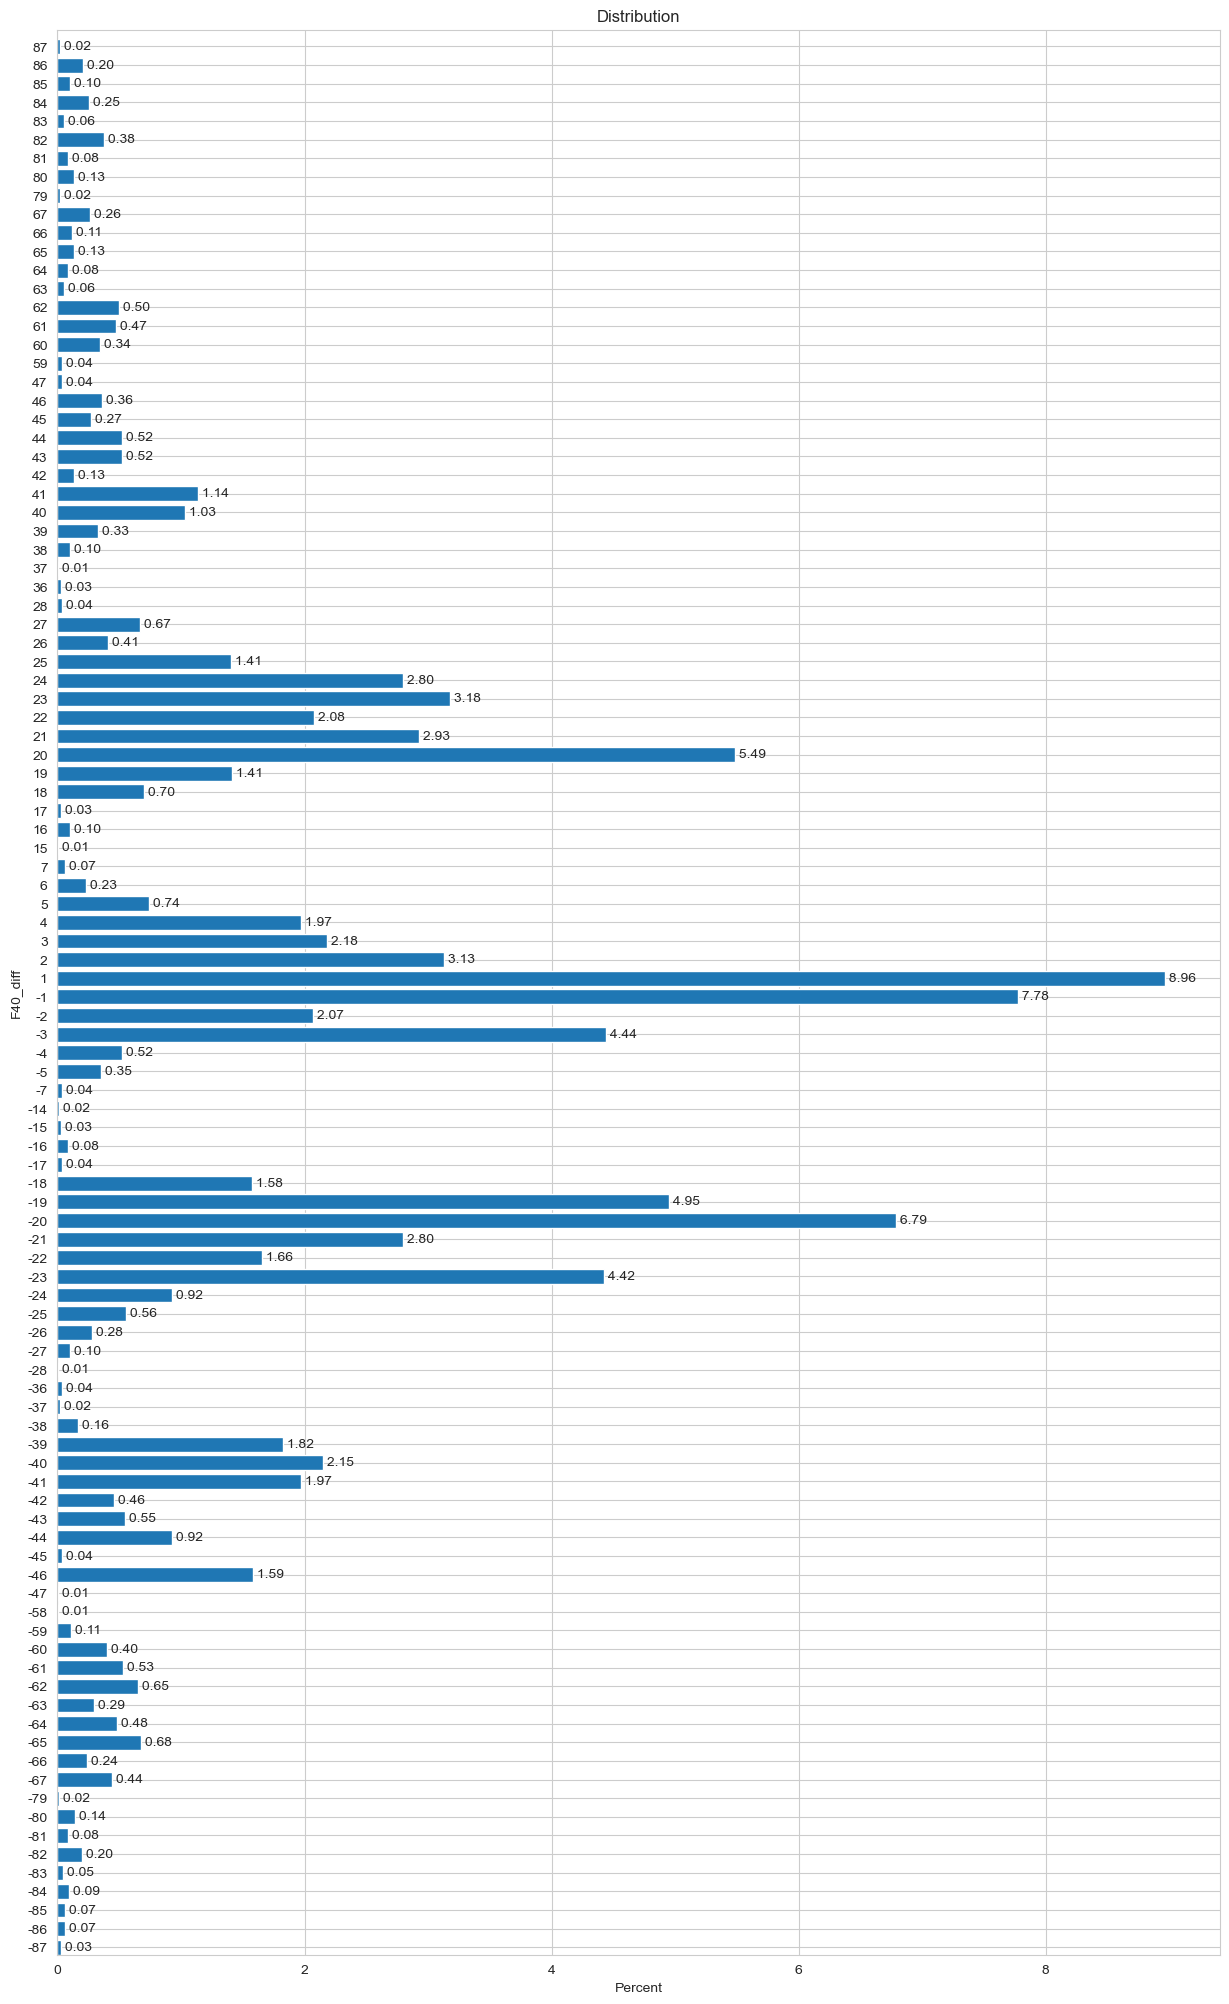

In [ ]:
misclass = df.loc[(df['FVT_Correct'] == False) & (df['F40_Correct'] == False)]
misclass['F40_diff'] = misclass['LF22_F40'] - misclass['PRED_LF22_F40']

plot_distribution(misclass, group_var='F40_diff', metric='Percent', sort=False, figsize=(15, 25))

### Further break down the results
Further statistics to explore how the predicted FVT values influence the F40 classification.

In [ ]:
total_cnt = len(df)

# Get overall F40 accuracy
F40_correct_cnt = df['F40_Correct'].sum()
F40_overall_acc = round(F40_correct_cnt / total_cnt * 100, 2)

print(f"The overall F40 accuracy is: {F40_overall_acc}% ({F40_correct_cnt} out of {total_cnt})")

# Get overall FVT accuracy
FVT_correct_cnt = df['FVT_Correct'].sum()
FVT_overall_acc = round(FVT_correct_cnt / total_cnt * 100, 2)

print(f"The overall FVT accuracy is: {FVT_overall_acc}% ({FVT_correct_cnt} out of {total_cnt})")


The overall F40 accuracy is: 76.01% (122924 out of 161723)
The overall FVT accuracy is: 89.41% (144591 out of 161723)


In [ ]:
# How did the F40 model perform with correct FVT classifications? 
FVT_corr_F40_incorr_cnt = df.loc[(df['FVT_Correct'] == True) & (df['F40_Correct'] == False)].shape[0]
FVT_corr_F40_incorr_perc = round(FVT_corr_F40_incorr_cnt / total_cnt * 100, 2)
print(f"{FVT_corr_F40_incorr_perc}% of observations had correct FVTs and incorrect F40s ({FVT_corr_F40_incorr_cnt} out of {total_cnt})")

FVT_corr_F40_corr_cnt = df.loc[(df['FVT_Correct'] == True) & (df['F40_Correct'] == True)].shape[0]
FVT_corr_F40_corr_perc = round(FVT_corr_F40_corr_cnt / total_cnt * 100, 2)
print(f"{FVT_corr_F40_corr_perc}% of observations had correct FVTs and correct F40s ({FVT_corr_F40_corr_cnt} out of {total_cnt})")


16.43% of observations had correct FVTs and incorrect F40s (26568 out of 161723)
72.98% of observations had correct FVTs and correct F40s (118023 out of 161723)


In [ ]:
# How did the model perform with incorrect FVT classifications? 
FVT_incorr = df.loc[df['FVT_Correct'] == False]
FVT_incorr_total = FVT_incorr.shape[0]

FVT_incorr_F40_corr_cnt = FVT_incorr.loc[FVT_incorr['F40_Correct'] == True].shape[0]
FVT_incorr_F40_corr_perc = round(FVT_incorr_F40_corr_cnt / FVT_incorr_total * 100, 2)

FVT_incorr_F40_incorr_cnt = FVT_incorr.loc[FVT_incorr['F40_Correct'] == False].shape[0]
FVT_incorr_F40_incorr_perc = round(FVT_incorr_F40_incorr_cnt / FVT_incorr_total * 100, 2)

print(f"Of observations where FVT was misclassed ({FVT_incorr_total}): ")
print(f"{FVT_incorr_F40_corr_perc}% of observations had correct F40 classifications ({FVT_incorr_F40_corr_cnt} of {FVT_incorr_total})")
print(f"{FVT_incorr_F40_incorr_perc}% of observations had incorrect F40 classifications ({FVT_incorr_F40_incorr_cnt} of {FVT_incorr_total})")

Of observations where FVT was misclassed (17132): 
28.61% of observations had correct F40 classifications (4901 of 17132)
71.39% of observations had incorrect F40 classifications (12231 of 17132)


# __FVC Predictions Evaluation - Raster__ 

## __Summary Statistics__ 

In [27]:
# Read in data 
raster_fpaths_dict = {
    "Predictions" : paths_dict['pred_FVC_raster'],
    "Original" : paths_dict['og_FVC_raster'],
    "LF22_FDST"  : paths_dict['LF22_FDST']
    }

data_dict = {}
for var, item in raster_fpaths_dict.items():
    with rasterio.open(item) as src:
        data = src.read()
        data_dict[var] = data.ravel()

# Create dataframe from dictionary of predictions/original
df = pd.DataFrame(data_dict)

# Process the data
# Remove observations with -9999/-1111 in any field 
df = df.loc[~df.isin([-1111, -9999]).any(axis=1)]

# Filter out points that weren't disturbed
df = df.loc[df['LF22_FDST'] != 0]

# Filter out agricultural and developed points
fvc_filter = list(range(20, 70)) + list(range(80, 86)) + [11, 12]
df = df.loc[~df['Original'].isin(fvc_filter)]

In [16]:
# Get results
results_dict = {
  "accuracy" : accuracy_score(df['Original'], df['Predictions']),
  "recall" : recall_score(df['Original'], df['Predictions'], average='macro', zero_division='warn'),
  "precision" : precision_score(df['Original'], df['Predictions'], average='macro', zero_division='warn')
}

results = pd.DataFrame([results_dict])
results

,accuracy,recall,precision
0,0.990727,0.872001,0.847989


## __FVC Visualizations__

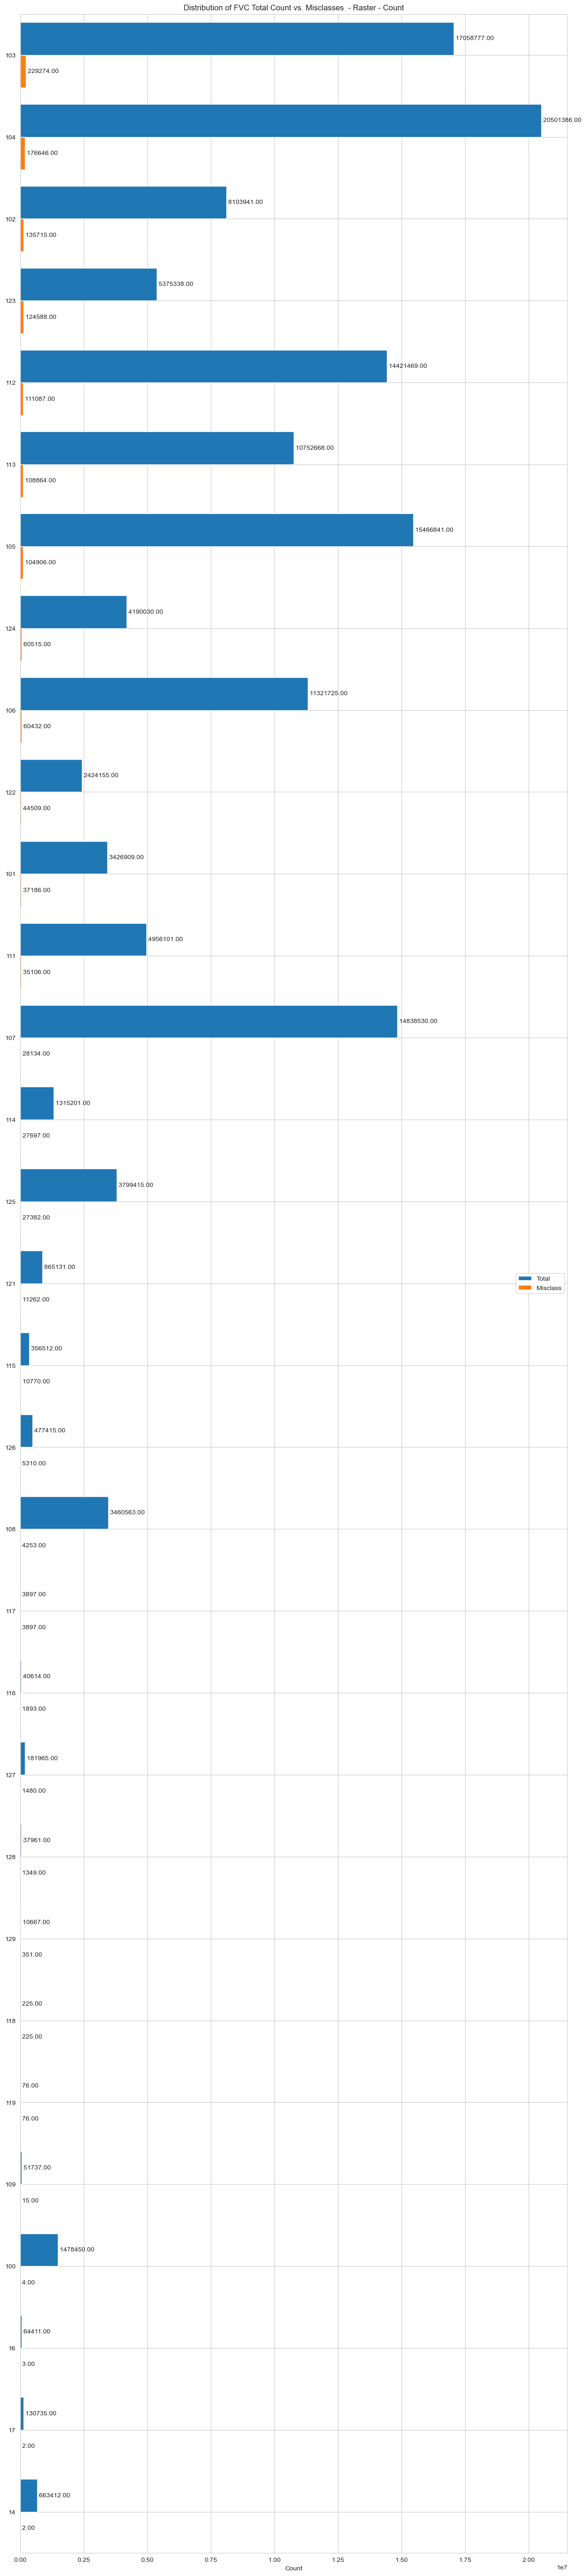

In [28]:

# Subset to misclassified observations
misclass = df.loc[~(df['Original'] == df['Predictions'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = df.loc[df['Original'].isin(misclass['Original'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Count'
title = f'Distribution of FVC Total Count vs. Misclasses  - Raster - {metric}'
plot_comparison_distribution(df_dict=df_dict, group_var='Original', metric=metric, title=title, figsize=(15, 70))


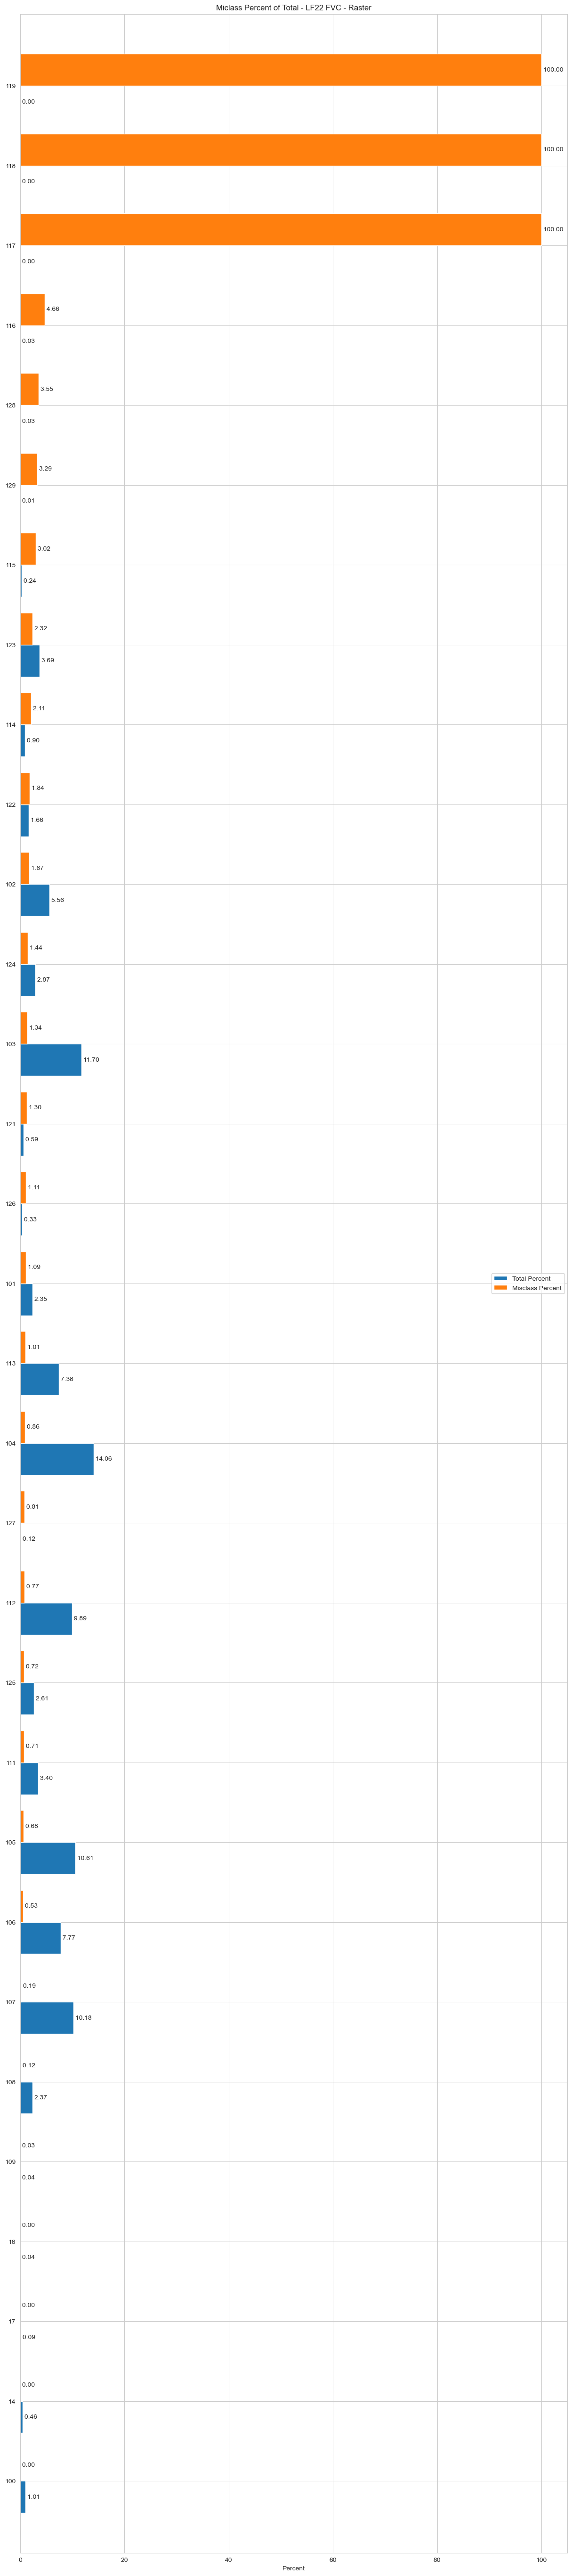

In [29]:
# Subset to misclassified observations
misclass = df.loc[~(df['Original'] == df['Predictions'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = df.loc[df['Original'].isin(misclass['Original'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Percent'
title = "Miclass Percent of Total - LF22 FVC - Raster"
plot_percent_total(df_dict=df_dict, group_var='Original', metric=metric, title=title, figsize=(15, 70))

# __FVH Predictions Evaluation__
----

In [40]:
# Read in data 
raster_fpaths_dict = {
    "Predictions" : paths_dict['pred_FVH_raster'],
    "Original" : paths_dict['og_FVH_raster'],
    "LF22_FDST"  : paths_dict['LF22_FDST']
    }

data_dict = {}
for var, item in raster_fpaths_dict.items():
    with rasterio.open(item) as src:
        data = src.read()
        data_dict[var] = data.ravel()

# Create dataframe from dictionary of predictions/original
df = pd.DataFrame(data_dict)

# Process the data
# Remove observations with -9999/-1111 in any field 
df = df.loc[~df.isin([-1111, -9999]).any(axis=1)]
print(f"After removing null points: {df.shape[0]}")

# Filter out points that weren't disturbed
df = df.loc[df['LF22_FDST'] != 0]
print(f"After removing undisturbed points: {df.shape[0]}")

# Filter out agricultural and developed points
fvh_filter = list(range(20, 70)) + list(range(80, 86)) + [11, 12]
df = df.loc[~df['Original'].isin(fvh_filter)]

After removing null points: 1094586641
After removing undisturbed points: 145899760


In [41]:
# Get results
results_dict = {
  "accuracy" : accuracy_score(df['Original'], df['Predictions']),
  "recall" : recall_score(df['Original'], df['Predictions'], average='macro', zero_division='warn'),
  "precision" : precision_score(df['Original'], df['Predictions'], average='macro', zero_division='warn')
}

results = pd.DataFrame([results_dict])
results

,accuracy,recall,precision
0,0.07902,0.143144,0.184525


## __FVH Visualizations__

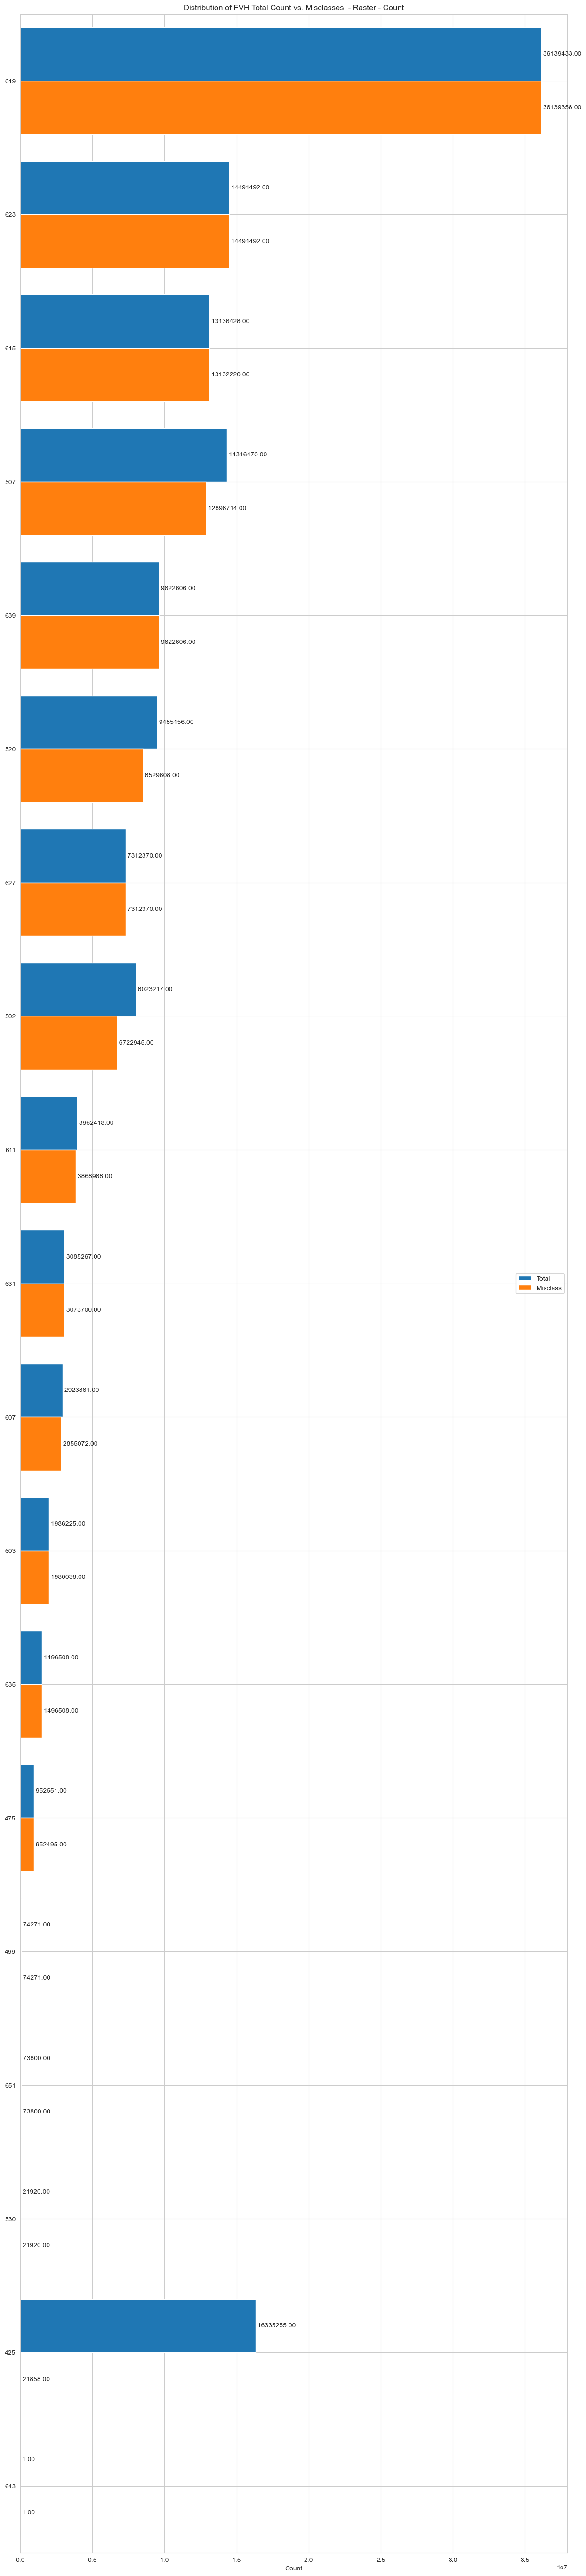

In [31]:

# Subset to misclassified observations
misclass = df.loc[~(df['Original'] == df['Predictions'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = df.loc[df['Original'].isin(misclass['Original'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Count'
title = f'Distribution of FVH Total Count vs. Misclasses  - Raster - {metric}'
plot_comparison_distribution(df_dict=df_dict, group_var='Original', metric=metric, title=title, figsize=(15, 70))


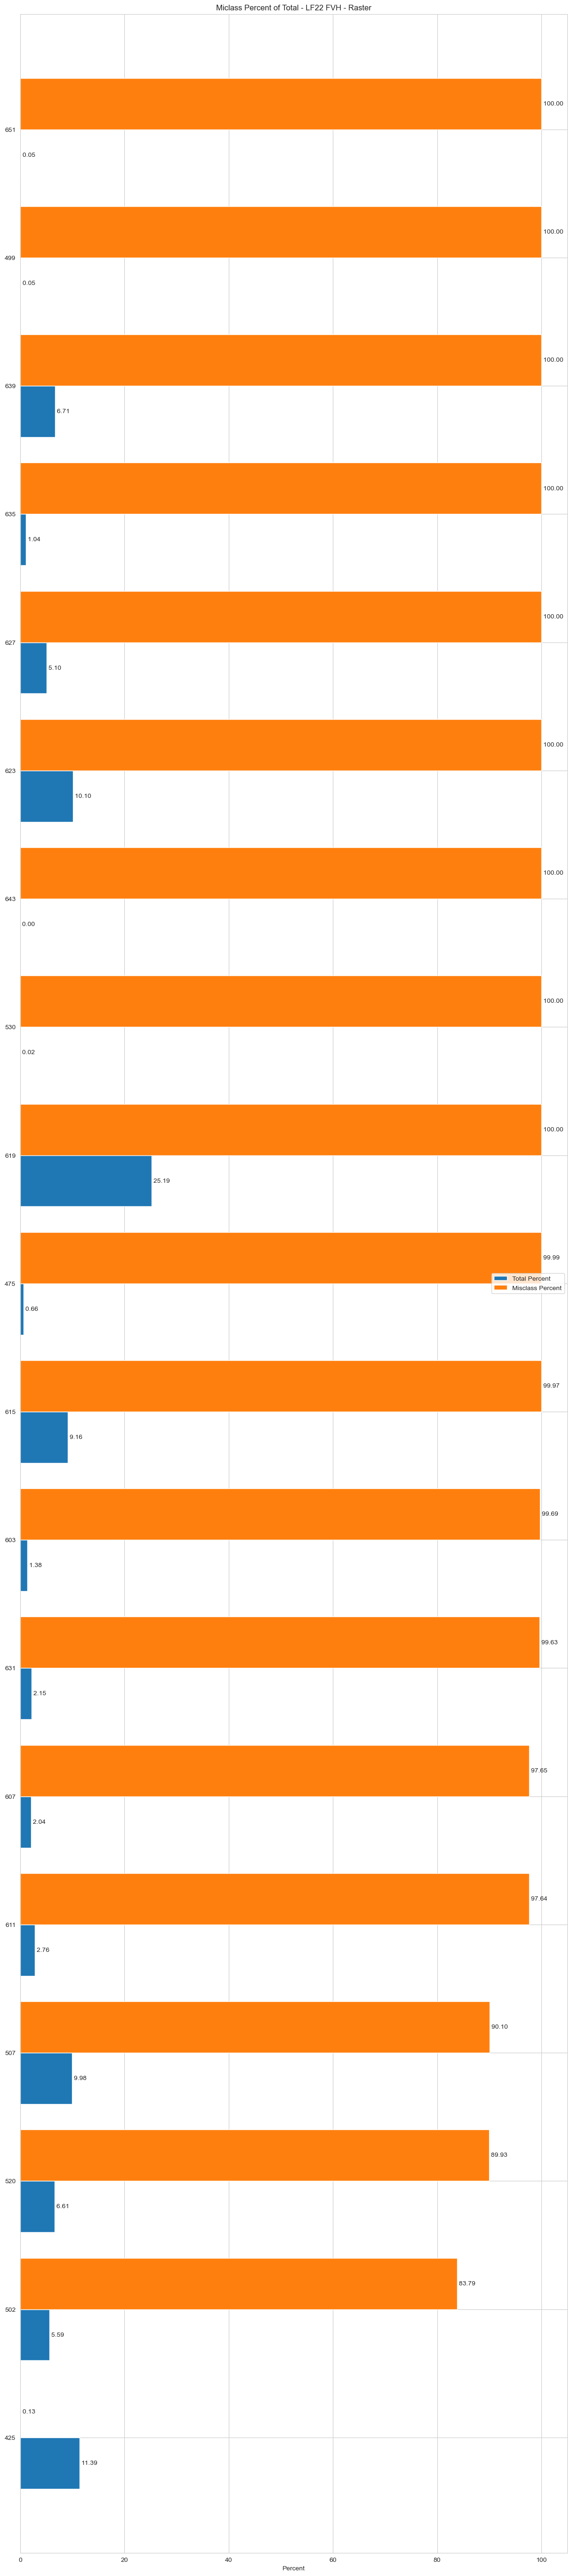

In [32]:
# Subset to misclassified observations
misclass = df.loc[~(df['Original'] == df['Predictions'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = df.loc[df['Original'].isin(misclass['Original'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Percent'
title = "Miclass Percent of Total - LF22 FVH - Raster"
plot_percent_total(df_dict=df_dict, group_var='Original', metric=metric, title=title, figsize=(15, 70))

# __F40 Predictions Evalutation__ 

## __Summary Statistics__ 

In [33]:
# Read in data 
raster_fpaths_dict = {
    "Predictions" : paths_dict['pred_F40_raster'],
    "Original" : paths_dict['og_F40_raster']
    }

data_dict = {}
for var, item in raster_fpaths_dict.items():
    with rasterio.open(item) as src:
        data = src.read()
        data_dict[var] = data.ravel()

# Create dataframe from dictionary of predictions/original
df = pd.DataFrame(data_dict)

# Process the data
## Remove observations with -9999/-1111 in any field 
df = df.loc[~df.isin([-1111, -9999]).any(axis=1)]

## Remove Non-Burnable Classes
F40_NB = [91, 92, 93, 98, 99]  # Nonburnable F40 Classes
df = df.loc[~df['Original'].isin(F40_NB)]  # Drop NB classes

KeyboardInterrupt: 

In [22]:
# Get results
results_dict = {
  "accuracy" : accuracy_score(df['Original'], df['Predictions']),
  "recall" : recall_score(df['Original'], df['Predictions'], average='macro', zero_division='warn'),
  "precision" : precision_score(df['Original'], df['Predictions'], average='macro', zero_division='warn')
}

results = pd.DataFrame([results_dict])
results

,accuracy,recall,precision
0,0.986083,0.904357,0.755048


## __F40 Visualizations__

In [ ]:

# Subset to misclassified observations
misclass = df.loc[~(df['Original'] == df['Predictions'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = df.loc[df['Original'].isin(misclass['Original'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Count'
title = f'Distribution of F40 Total Count vs. Misclasses  - Raster - {metric}'
plot_comparison_distribution(df_dict=df_dict, group_var='Original', metric=metric, title=title, figsize=(15, 70))


In [ ]:
# Subset to misclassified observations
misclass = df.loc[~(df['Original'] == df['Predictions'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = df.loc[df['Original'].isin(misclass['Original'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Percent'
title = "Miclass Percent of Total - LF22 F40 - Raster"
plot_percent_total(df_dict=df_dict, group_var='Original', metric=metric, title=title, figsize=(15, 70))